In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import kagglehub

path = kagglehub.dataset_download("zeyadkhalid/mbti-personality-types-500-dataset")
print("Path to dataset files:", path)

df = pd.read_csv(f"{path}/MBTI 500.csv")
df = df.dropna(subset=['type', 'posts'])

vectorizer = TfidfVectorizer(max_features=1000, max_df=0.9)
X = vectorizer.fit_transform(df['posts']).toarray()

df['I_E'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['N_S'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['T_F'] = df['type'].apply(lambda x: 1 if x[2] == 'F' else 0)
df['J_P'] = df['type'].apply(lambda x: 1 if x[3] == 'P' else 0)

def downsample(df, target_col):
    minority_class_size = df[target_col].value_counts().min()
    df_majority = df[df[target_col] == df[target_col].value_counts().idxmax()]
    df_minority = df[df[target_col] == df[target_col].value_counts().idxmin()]
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=minority_class_size,
        random_state=42
    )
    df_balanced = pd.concat([df_majority_downsampled, df_minority])
    return df_balanced

df_ie_balanced = downsample(df, 'I_E')
df_ns_balanced = downsample(df, 'N_S')
df_tf_balanced = downsample(df, 'T_F')
df_jp_balanced = downsample(df, 'J_P')

print("I_E Balance:\n", df_ie_balanced['I_E'].value_counts())
print("N_S Balance:\n", df_ns_balanced['N_S'].value_counts())
print("T_F Balance:\n", df_tf_balanced['T_F'].value_counts())
print("J_P Balance:\n", df_jp_balanced['J_P'].value_counts())


100%|██████████| 123M/123M [00:04<00:00, 25.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zeyadkhalid/mbti-personality-types-500-dataset/versions/1
I_E Balance:
 I_E
0    25390
1    25390
Name: count, dtype: int64
N_S Balance:
 N_S
0    9201
1    9201
Name: count, dtype: int64
T_F Balance:
 T_F
0    36864
1    36864
Name: count, dtype: int64
J_P Balance:
 J_P
1    44435
0    44435
Name: count, dtype: int64


In [ ]:
def train_and_predict_rf(X_train, y_train, X_test, y_test, label):
    model = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {label}: {accuracy}")
    return model

def prepare_and_train_rf(df_balanced, label):
    X_balanced = vectorizer.transform(df_balanced['posts']).toarray()
    y_balanced = df_balanced[label]
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
    model = train_and_predict_rf(X_train, y_train, X_test, y_test, label)
    return model, X_test, y_test

model_ie, X_test_ie, y_test_ie = prepare_and_train_rf(df_ie_balanced, 'I_E')
model_ns, X_test_ns, y_test_ns = prepare_and_train_rf(df_ns_balanced, 'N_S')
model_tf, X_test_tf, y_test_tf = prepare_and_train_rf(df_tf_balanced, 'T_F')
model_jp, X_test_jp, y_test_jp = prepare_and_train_rf(df_jp_balanced, 'J_P')

def calculate_final_accuracy_rf(X_test, y_test_full):
    predictions = []
    for x in X_test:
        x = x.reshape(1, -1)
        ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
        ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
        tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
        jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
        predictions.append(ie + ns + tf + jp)

    correct_predictions = sum([1 for true, pred in zip(y_test_full, predictions) if true == pred])
    final_accuracy = correct_predictions / len(y_test_full)
    return final_accuracy

X_full_test, y_full_test = vectorizer.transform(df['posts']).toarray(), df['type']
final_accuracy_rf = calculate_final_accuracy_rf(X_full_test, y_full_test)
print("Final MBTI Prediction Accuracy (Random Forest):", final_accuracy_rf)

def predict_mbti_rf(text):
    x = vectorizer.transform([text]).toarray()
    ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
    ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
    tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
    jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
    return ie + ns + tf + jp

sample_text = "I enjoy deep conversations and reflecting on philosophical topics."
predicted_mbti_rf = predict_mbti_rf(sample_text)
print("Predicted MBTI (Random Forest):", predicted_mbti_rf)


Accuracy for I_E: 0.8370421425758172
Accuracy for N_S: 0.8668839989133388
Accuracy for T_F: 0.8860707988607079
Accuracy for J_P: 0.8451670980083268
Final MBTI Prediction Accuracy (Random Forest): 0.7205162774472739
Predicted MBTI (Random Forest): ISTP


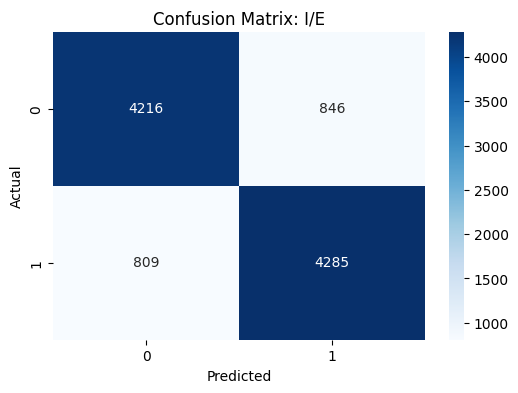

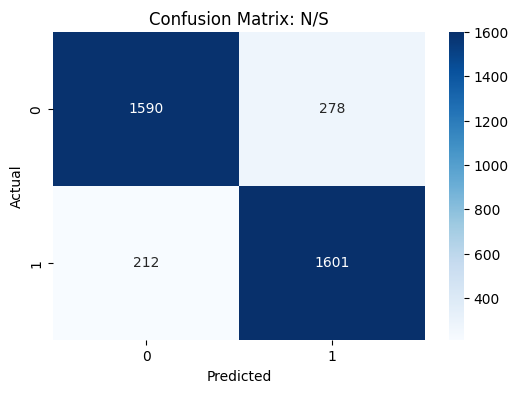

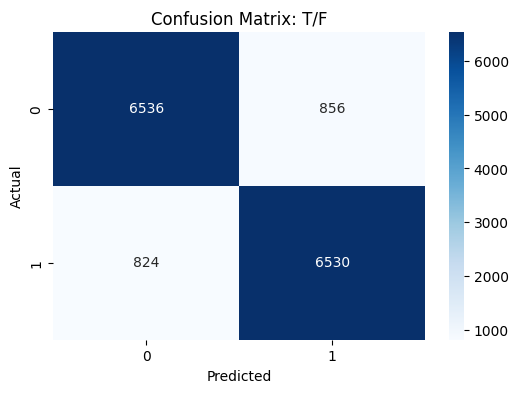

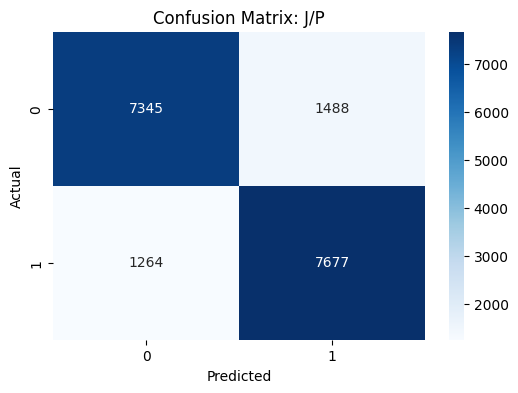

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def calculate_and_plot_confusion(models, X_tests, y_tests, labels):
    for model, X_test, y_test, label in zip(models, X_tests, y_tests, labels):
        y_pred = model.predict(X_test)
        plot_confusion_matrix(y_test, y_pred, title=label)

models = [model_ie, model_ns, model_tf, model_jp]
X_tests = [X_test_ie, X_test_ns, X_test_tf, X_test_jp]
y_tests = [y_test_ie, y_test_ns, y_test_tf, y_test_jp]
labels = ["I/E", "N/S", "T/F", "J/P"]

calculate_and_plot_confusion(models, X_tests, y_tests, labels)
